# Import

In [1]:
using JLD
using PyPlot
using LinearAlgebra

# 4

Squared train Error with least squares: 37

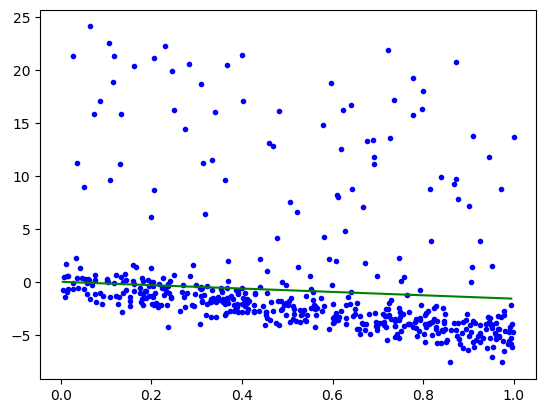

.643
Squared test Error with least squares: 5.238


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f00c61e6da0>

In [2]:
include("example_outliers.jl")

# 4.1

In [3]:
function weightedLeastSquare(X,y,v)
	# Find regression weights minimizing squared error
    V = Diagonal(reshape(v, (length(v),)))
	w = (X' * V * X)\(X' * V * y)

	# Make linear prediction function
	predict(Xhat) = Xhat * w
    
	# Return model
	return GenericModel(predict)
end


weightedLeastSquare (generic function with 1 method)

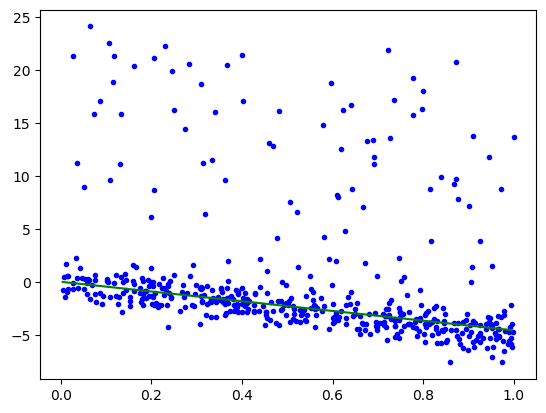

Squared train Error with least squares: 40.873
Squared test Error with least squares: 1.168


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f00c1a78668>

In [4]:
v = [ones(400, 1); 0.1* ones(100,1)]

data = load("outliersData.jld")
(X,y,Xtest,ytest) = (data["X"],data["y"],data["Xtest"],data["ytest"])

# Fit a least squares model
model = weightedLeastSquare(X,y,v)

# Evaluate training error
yhat = model.predict(X)
trainError = mean((yhat - y).^2)
@printf("Squared train Error with least squares: %.3f\n",trainError)

# Evaluate test error
yhat = model.predict(Xtest)
testError = mean((yhat - ytest).^2)
@printf("Squared test Error with least squares: %.3f\n",testError)

# Plot model
using PyPlot
figure()
plot(X,y,"b.")
Xhat = minimum(X):.01:maximum(X)
yhat = model.predict(Xhat)
plot(Xhat,yhat,"g")

# 4.3 gradient descent

User and numerical derivatives agree
 

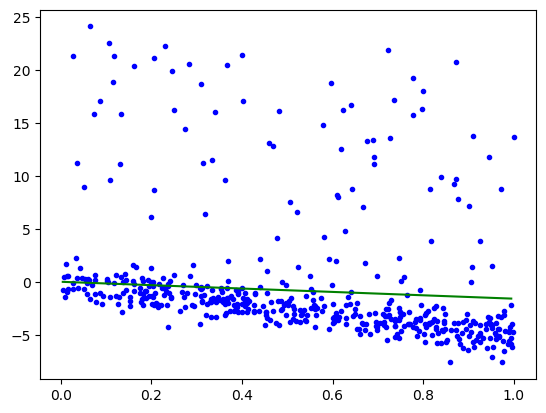

    1     3.48248e-03     9.44266e+03     1.07258e+02
     2     3.48248e-03     9.41514e+03     4.00635e+01
     3     3.48248e-03     9.41131e+03     1.49647e+01
     4     3.48248e-03     9.41077e+03     5.58966e+00
     5     3.48248e-03     9.41070e+03     2.08787e+00
     6     3.48248e-03     9.41069e+03     7.79871e-01
     7     3.48248e-03     9.41068e+03     2.91300e-01
     8     3.48248e-03     9.41068e+03     1.08808e-01
     9     3.48248e-03     9.41068e+03     4.06423e-02
    10     3.48248e-03     9.41068e+03     1.51809e-02
    11     3.48248e-03     9.41068e+03     5.67042e-03
Problem solved up to optimality tolerance
Squared train Error with least squares: 37.643
Squared test Error with least squares: 5.238


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f00c1a5f898>

In [5]:
include("example_gradient.jl")

In [6]:
function leastSquaresGradient(X,y)

	(n,d) = size(X)

	# Initial guess
	w = zeros(d,1)

	# Function we're going to minimize (and that computes gradient)
	funObj(w) = leastSquaresHuber(w,X,y,1)

	# This is how you compute the function and gradient:
	(f,g) = funObj(w)

	# Derivative check that the gradient code is correct:
	g2 = numGrad(funObj,w)

    println(g , " ", g2)
    
	if maximum(abs.(g-g2)) > 1e-4
		@printf("User and numerical derivatives differ:\n")
		@show([g g2])
	else
		@printf("User and numerical derivatives agree\n")
	end

	# Solve least squares problem
	w = findMin(funObj,w)

	# Make linear prediction function
	predict(Xhat) = Xhat*w

	# Return model
	return GenericModel(predict)
end

function leastSquaresHuber(w,X,y, epsilon)
    Xw = X*w

    f = Xw-y
    case1 = abs.(f) .< epsilon
    case2 = .!case1
    case1 = reshape(case1, length(case1))
    case2 = reshape(case2, length(case2))
    
    g = zeros(size(w))
    g .+= X[case1, :]' * f[case1] 
    g .+= epsilon * X[case2, :]' * sign.(f[case2])

    f[case1] = (f[case1].^2)./2
    f[case2] = epsilon * (abs.(f[case2]) .- epsilon/2)
    
    return (sum(f),g)
end



leastSquaresHuber (generic function with 1 method)

[162.56402972372527] [162.56402977887774]
User and numerical derivatives agree
 

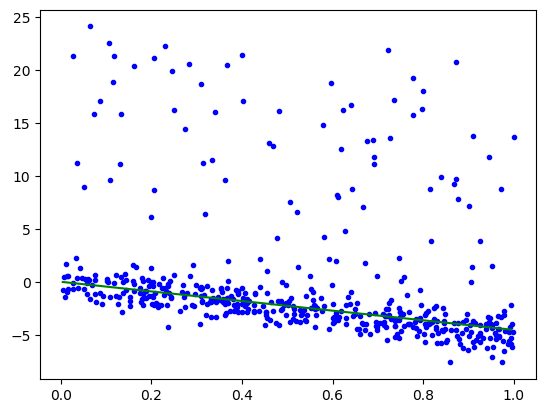

    1     6.15142e-03     1.70436e+03     1.52588e+02
     2     6.15142e-03     1.56642e+03     1.39946e+02
     3     6.15142e-03     1.45485e+03     1.16613e+02
     4     6.15142e-03     1.38223e+03     8.22967e+01
     5     6.15142e-03     1.34943e+03     4.57558e+01
     6     6.15142e-03     1.33979e+03     2.22954e+01
     7     6.15142e-03     1.33758e+03     9.84809e+00
     8     6.15142e-03     1.33715e+03     4.19397e+00
     9     6.15142e-03     1.33707e+03     1.79473e+00
    10     6.15142e-03     1.33706e+03     7.61178e-01
    11     6.15142e-03     1.33706e+03     3.18948e-01
    12     6.15142e-03     1.33706e+03     1.33646e-01
    13     6.15142e-03     1.33706e+03     5.60001e-02
    14     6.15142e-03     1.33706e+03     2.34651e-02
    15     6.15142e-03     1.33706e+03     9.83235e-03
Problem solved up to optimality tolerance
Squared train Error with least squares: 40.776
Squared test Error with least squares: 1.184


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f00c19c8358>

In [7]:
data = load("outliersData.jld")
(X,y,Xtest,ytest) = (data["X"],data["y"],data["Xtest"],data["ytest"])

# X = [X X.^2]

# Xtest = [Xtest Xtest.^2]


model = leastSquaresGradient(X,y)

# Evaluate training error
yhat = model.predict(X)
trainError = mean((yhat - y).^2)
@printf("Squared train Error with least squares: %.3f\n",trainError)

# Evaluate test error
yhat = model.predict(Xtest)
testError = mean((yhat - ytest).^2)
@printf("Squared test Error with least squares: %.3f\n",testError)

# Plot model
using PyPlot
figure()
plot(X,y,"b.")
Xhat = minimum(X):.01:maximum(X)
yhat = model.predict(Xhat)
plot(Xhat,yhat,"g")
